In [1]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(523)

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import seaborn as sns
sns.set_style("ticks")
sns.set_context("talk")

color_names = ["windows blue",
               "red",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "mint",
               "light cyan",
               "steel blue",
               "forest green",
               "pastel purple",
               "salmon",
               "dark brown"]
colors = sns.xkcd_palette(color_names)

from ssm import HMM
from ssm.util import find_permutation, one_hot

In [2]:
# Setup and simulate from a Poisson HMM

T = 2000   # number of time bins
D = 25     # number of observed neurons
K = 5      # number of states

# Make an LDS with somewhat interesting dynamics parameters
true_hmm = HMM(K, D, observations="poisson") 
P = np.eye(K) + 0.2 * np.diag(np.ones(K-1), k=1) + 1e-5 * np.ones((K,K))
P[-1,0] = 0.2
true_hmm.transitions.log_Ps = np.log(P)

log_lambdas = np.log(0.01 * np.ones((K, D)))
for k in range(K):
    log_lambdas[k,k*K:(k+1)*K] = np.log(0.2)
true_hmm.observations.log_lambdas = log_lambdas

z, y = true_hmm.sample(T)
z_test, y_test = true_hmm.sample(T)

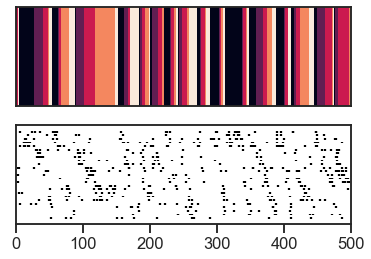

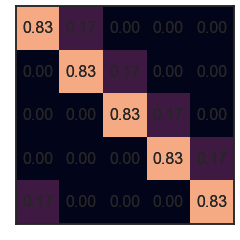

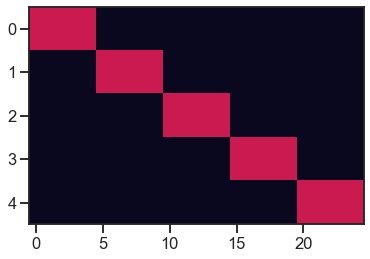

In [3]:
# visualize
T_plot=500
plt.figure()
plt.subplot(211)
plt.imshow(z[None,:], aspect="auto")
plt.xlim([0,T_plot])
plt.xticks([])
plt.yticks([])
plt.subplot(212)
# plt.plot(y)
for n in range(D):
    plt.eventplot(np.where(y[:,n]>0)[0]+1, linelengths=0.5, lineoffsets=D-n,color='k')
plt.xlim([0,T_plot])
plt.yticks([])

def plot_transition_matrix(transition_matrix, fontsize=16):
    plt.imshow(transition_matrix, vmin=0.0, vmax=1.0, aspect="auto")
    for (j,i),label in np.ndenumerate(transition_matrix):
        plt.text(i,j,'%.2f' % label,ha='center',va='center', fontsize=fontsize)
        plt.text(i,j,'%.2f' % label,ha='center',va='center', fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_aspect("equal")

plt.figure()
plot_transition_matrix(true_hmm.transitions.transition_matrix)

def plot_log_lambdas(model):
    plt.imshow(np.exp(model.observations.log_lambdas), vmin=0.0, vmax=0.4, aspect="auto")

plt.figure()
plot_log_lambdas(true_hmm)

(0, 500)

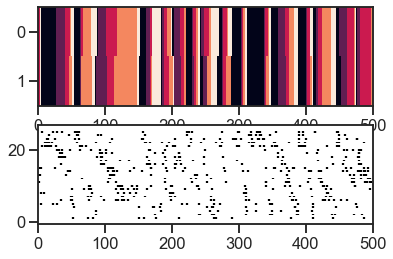

In [4]:
# Fit 10 Poisson HMMs to the data and keep the best one
N = 10
max_ll = -np.inf
for n in range(N):
    test_hmm_temp = HMM(K, D, observations="poisson") 
    poiss_lls_temp = test_hmm_temp.fit(y, num_iters=50)
    if poiss_lls_temp[-1] > max_ll:
        max_ll = poiss_lls_temp[-1]
        poiss_lls = poiss_lls_temp 
        test_hmm = test_hmm_temp
# test_hmm = HMM(K, D, observations="poisson") 
# poiss_lls = test_hmm.fit(y, num_iters=20)
test_hmm.permute(find_permutation(z, test_hmm.most_likely_states(y)))
smoothed_z = test_hmm.most_likely_states(y)

plt.figure()
plt.subplot(211)
plt.imshow(np.row_stack((z, smoothed_z)), aspect="auto")
plt.xlim([0,T_plot])
plt.subplot(212)
# plt.plot(y)
for n in range(D):
    plt.eventplot(np.where(y[:,n]>0)[0]+1, linelengths=0.5, lineoffsets=D-n,color='k')
plt.xlim([0,T_plot])


([], <a list of 0 Text yticklabel objects>)

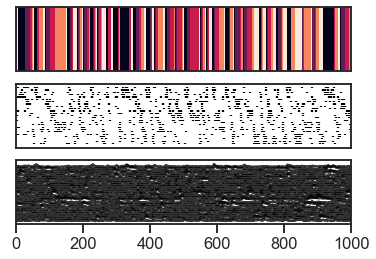

In [38]:
# Setup Calcium observations and simulate from them
As = np.clip(0.8 + 0.1 * npr.randn(D), 0.6, 0.95)
betas = 1.0 * np.ones(D)
inv_etas = np.log(1e-2 * np.ones(D))
etas = np.exp(inv_etas)
mus = np.zeros_like(y) # start with zero mean
mus_test = np.zeros_like(y_test) 
y_ca = np.zeros((T, D))
y_ca_test = np.zeros((T, D))
y_ca[0] = mus[0, :] + np.sqrt(etas) * npr.randn(D) + betas * y[0, :]
y_ca_test[0] = mus[0, :] + np.sqrt(etas) * npr.randn(D) + betas * y_test[0, :]
for t in range(1, T):
    y_ca[t] = mus[t, :] + As * y_ca[t-1] + betas * y[t, :] + np.sqrt(etas) * npr.randn(D)
    y_ca_test[t] = mus_test[t, :] + As * y_ca_test[t-1] + betas * y_test[t, :] + np.sqrt(etas) * npr.randn(D)

# add per time point noise afterwards (not part of Ganmor generative model)
y_ca = y_ca + 0.2 * npr.randn(*y_ca.shape)
y_ca_test = y_ca_test + 0.2 * npr.randn(*y_ca_test.shape)

# T_plot
T_plot=1000
plt.figure()
plt.subplot(311)
plt.imshow(z[None,:], aspect="auto")
plt.xlim([0,T_plot])
plt.xticks([])
plt.yticks([])
plt.subplot(312)
# plt.plot(y)
for n in range(D):
    plt.eventplot(np.where(y[:,n]>0)[0]+1, linelengths=0.5, lineoffsets=D-n,color='k')
plt.xlim([0,T_plot])
plt.xticks([])
plt.yticks([])
plt.subplot(313)
for n in range(D):
    plt.plot(y_ca[:, n] + 2.5 * (D-n), '-k', alpha=0.8)
    # plt.plot(y_ca_test2[:, n] + 2.5 * (D-n), '-g', alpha=0.8)
# y_dff = (y_ca - np.min(y_ca,axis=0)) / np.max(y_ca, axis=0)
# plt.imshow( y_dff.T, aspect="auto")
plt.xlim([0,T_plot])
plt.yticks([])

In [6]:
# Fit a Gaussian HMM to the calcium observations
N = 10
max_ll = -np.inf
for n in range(N):
    test_hmm_temp = HMM(K, D, observations="gaussian") 
    gauss_lls_temp = test_hmm_temp.fit(y_ca, num_iters=50)
    if gauss_lls_temp[-1] > max_ll:
        max_ll = gauss_lls_temp[-1]
        gauss_lls = gauss_lls_temp 
        test_hmm_gauss = test_hmm_temp
# test_hmm_gauss = HMM(K, D, observations="gaussian") 
# gauss_lls = test_hmm_gauss.fit(y_ca, num_iters=20)
test_hmm_gauss.permute(find_permutation(z, test_hmm_gauss.most_likely_states(y_ca)))
smoothed_z_gauss = test_hmm_gauss.most_likely_states(y_ca)
smoothed_y_gauss = test_hmm_gauss.smooth(y_ca)

In [7]:
# Fit an AR-HMM to the calcium observations
N = 10
max_ll = -np.inf
for n in range(N):
    test_hmm_temp = HMM(K, D, observations="diagonal_ar") 
    ar_lls_temp = test_hmm_temp.fit(y_ca, num_iters=50)
    if ar_lls_temp[-1] > max_ll:
        max_ll = ar_lls_temp[-1]
        ar_lls = ar_lls_temp 
        test_hmm_ar = test_hmm_temp
test_hmm_ar.permute(find_permutation(z, test_hmm_ar.most_likely_states(y_ca)))
smoothed_z_ar = test_hmm_ar.most_likely_states(y_ca)
smoothed_y_ar = test_hmm_ar.smooth(y_ca)

In [8]:
# initialize and fit a calcium hmm
test_hmm_ca = HMM(K, D, observations="calcium") 
test_As = np.zeros_like(As)
test_etas = np.zeros_like(etas)
for d in range(D):
    yd = y_ca[:,d]
    test_As[d] = 1.0 / np.sum(yd[:-1] **2 ) * np.dot(yd[:-1], yd[1:]) * 1.0 # deflate because not taking into account spikes
    sqerr = np.sum( ( yd[1:] - test_As[d] * yd[:-1] )**2 ) / (T-1)
    test_etas[d] = sqerr 

inv_betas = np.log(1.0 * np.ones(D) + 0.2 * npr.randn(D))
inv_etas = np.log(test_etas)
inv_As = np.log(test_As)
test_hmm_ca.observations.params = \
    (test_hmm_ca.observations.log_lambdas, inv_As, inv_betas, inv_etas) 
ca_lls = test_hmm_ca.fit(y_ca, num_iters=20, observations_mstep_kwargs={"num_iters":100})
test_hmm_ca.permute(find_permutation(z, test_hmm_ca.most_likely_states(y_ca)))
smoothed_z_ca = test_hmm_ca.most_likely_states(y_ca)
smoothed_y_ca = test_hmm_ca.smooth(y_ca)


/Users/dz5/github/ssm/ssm/optimizers.py:132: UserWarning: L-BFGS-B failed with message:
b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  warn("{} failed with message:\n{}".format(method, result.message))


(0, 1000)

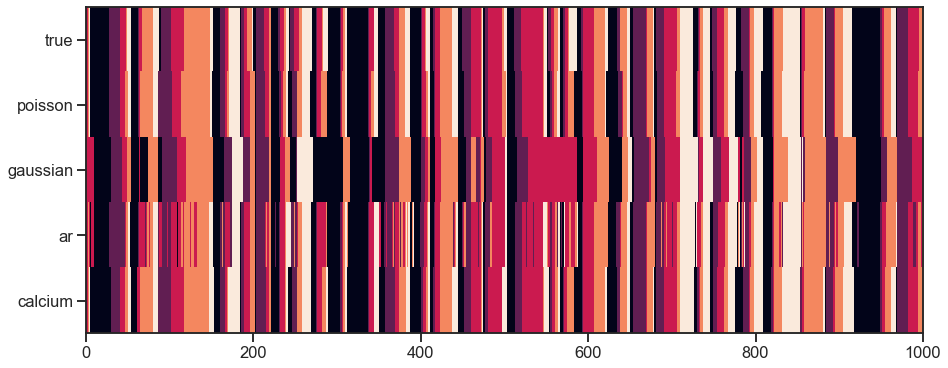

In [16]:
plt.figure(figsize=[15,6])
plt.imshow(np.row_stack((z, smoothed_z, smoothed_z_gauss, smoothed_z_ar, smoothed_z_ca)), aspect="auto")
plt.yticks([0,1,2,3,4],["true","poisson","gaussian","ar","calcium"])
plt.ylim([4.5,-0.5])
plt.xlim([0, T_plot])

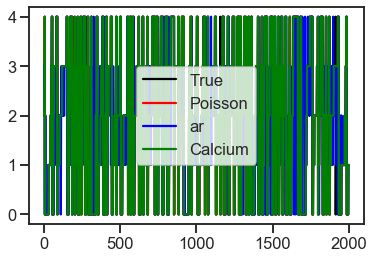

In [17]:
plt.figure()
plt.plot(z, 'k', label="True")
plt.plot(smoothed_z, 'r', label="Poisson")
# plt.plot(smoothed_z_gauss, 'b', label="Gaussian")
plt.plot(smoothed_z_ar, 'b', label="ar")
plt.plot(smoothed_z_ca, 'g', label="Calcium")
plt.legend()

In [39]:
# test data
# y_ca_test = y_ca_test + 0.2 * npr.randn(*y_ca_test.shape)
poiss_test_ll = test_hmm.log_likelihood(y_test)
ca_test_ll = test_hmm_ca.log_likelihood(y_ca_test)
gauss_test_ll = test_hmm_gauss.log_likelihood(y_ca_test)
ar_test_ll = test_hmm_ar.log_likelihood(y_ca_test)

smoothed_z_test = test_hmm.most_likely_states(y_test)
smoothed_z_ca_test = test_hmm_ca.most_likely_states(y_ca_test)
smoothed_z_gauss_test = test_hmm_gauss.most_likely_states(y_ca_test)
smoothed_z_gauss_ar_test = test_hmm_ar.most_likely_states(y_ca_test)

Test log likelihoods
Gaussian:  -47321.01077338079
AR:  -24193.30063272267
Calcium:  -17160.131607460524


Text(0.5, 1.0, 'Most Likely Discrete States on Test Data')

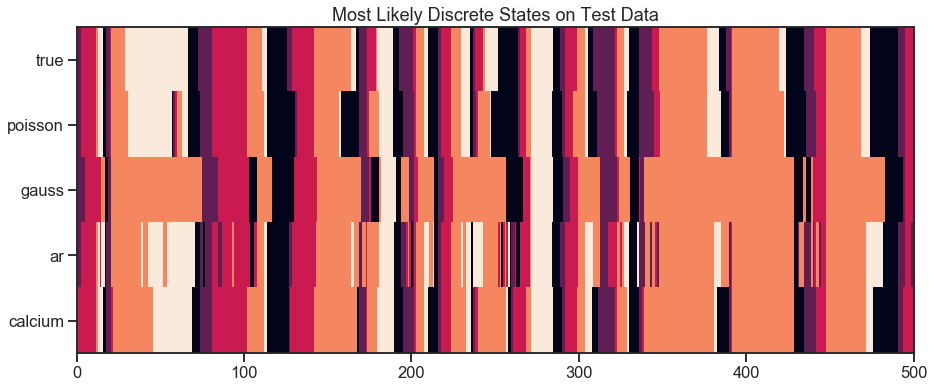

In [48]:
print("Test log likelihoods")
print("Gaussian: ", gauss_test_ll)
print("AR: ", ar_test_ll)
print("Calcium: ", ca_test_ll)

plt.figure(figsize=[15,6])
plt.imshow(np.row_stack((z_test, smoothed_z_test, smoothed_z_gauss_test, smoothed_z_gauss_ar_test, smoothed_z_ca_test)), aspect="auto")
plt.xlim([0, 500])
plt.yticks([0,1,2,3,4],["true","poisson","gauss","ar","calcium"])
plt.ylim([4.5,-0.5])
plt.title("Most Likely Discrete States on Test Data")

(200, 300)

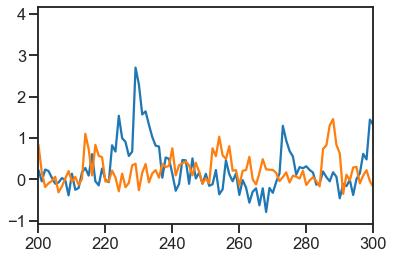

In [42]:
# plt.figure(figsize=[15,10])
# for n in range(D):
#     plt.plot(y_ca[:, n] + 3 * (D-n), '-k', label="True" if n == 0 else None)
#     plt.plot(smoothed_y_gauss[:, n] + 3 * (D-n), '-b', label="Gaussian" if n == 0 else None)
#     plt.plot(smoothed_y_ca[:, n] + 3 * (D-n), '-g', label="Calcium" if n == 0 else None)
# plt.xlim([0, 100])
plt.figure()
plt.plot(y_ca[:,0])
plt.plot(y_ca_test[:,0])
plt.xlim([200,300])

(0, 100)

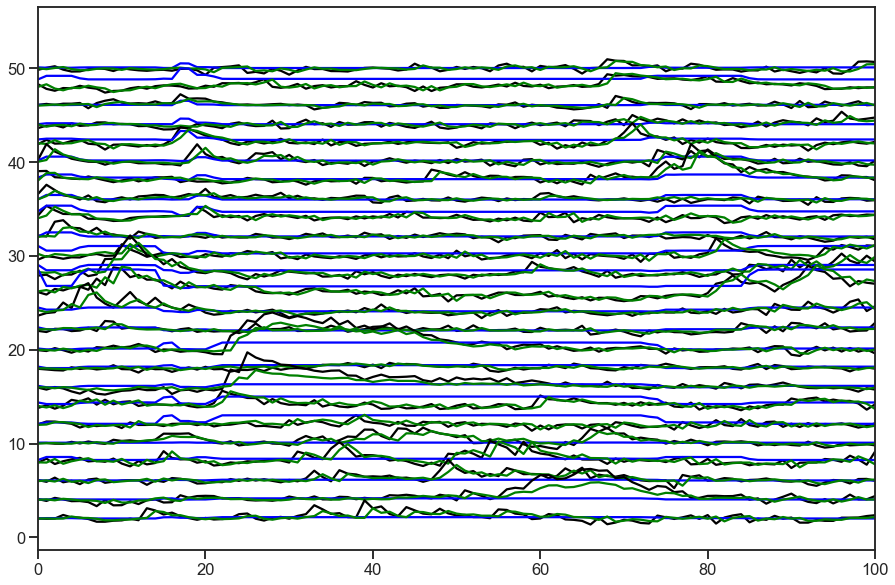

In [43]:
smoothed_y_ca_test_gauss = test_hmm_gauss.smooth(y_ca_test)
smoothed_y_ca_test_ca = test_hmm_ca.smooth(y_ca_test)

plt.figure(figsize=[15,10])
for n in range(D):
    plt.plot(y_ca_test[:, n] + 2 * (D-n), '-k', label="True" if n == 0 else None)
    plt.plot(smoothed_y_ca_test_gauss[:, n] + 2 * (D-n), '-b', label="Gaussian" if n == 0 else None)
    plt.plot(smoothed_y_ca_test_ca[:, n] + 2 * (D-n), '-g', label="Calcium" if n == 0 else None)
plt.xlim([0, 100])

Text(0.5, 1.0, 'ganmor')

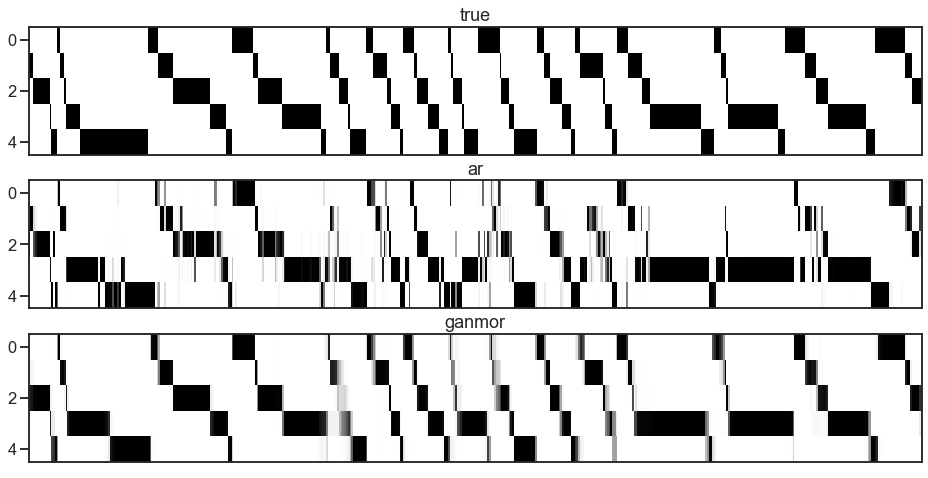

In [52]:
# posterior expectations
# poiss_expectations = test_hmm.expected_states(y)[0]
ar_expectations = test_hmm_ar.expected_states(y_ca_test)[0]
ganmor_expectations = test_hmm_ca.expected_states(y_ca_test)[0]

T_plot = 500
plt.figure(figsize=[16,8])
plt.subplot(311)
plt.imshow(one_hot(z_test, K=K).T, aspect="auto", vmin=0.0, vmax=1.0, cmap="Greys")
plt.title("true")
plt.xlim([0, T_plot])
plt.xticks([])
plt.subplot(312)
plt.imshow(ar_expectations.T, aspect="auto", vmin=0.0, vmax=1.0, cmap="Greys")
plt.xlim([0, T_plot])
plt.xticks([])
plt.title("ar")
plt.subplot(313)
plt.imshow(ganmor_expectations.T, aspect="auto", vmin=0.0, vmax=1.0, cmap="Greys")
plt.xlim([0, T_plot])
plt.xticks([])
plt.title("ganmor")